In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os

TRAIN_DATA_PATH = '/kaggle/input/airbus-ship-detection/train_v2'
TEST_DATA_PATH = '/kaggle/input/airbus-ship-detection/test_v2'

## **Data uploading and visualisation**

In [2]:
train_data = os.listdir(TRAIN_DATA_PATH)
test_data = os.listdir(TEST_DATA_PATH)
tr_img = PIL.Image.open(os.path.join(TRAIN_DATA_PATH, train_data[10]))
print(f'Train set size: {len(train_data)}\nTest set size: {len(test_data)}')
print(f'Initial image size: {tr_img.size}')

Train set size: 192556
Test set size: 15606
Initial image size: (768, 768)


In [3]:
def show_imgs(x, y, increment, img_names, folder_path, msk_pnts=None):
    """
    Display images and corresponding masks in a grid layout.
    Args:
        x (int): Number of rows in the grid.
        y (int): Number of columns in the grid.
        increment (int): Increment value for selecting images from the list.
        img_names (list): List of image names.
        folder_path (str): Path to the folder containing the images.
        msk_pnts (list, optional): List of mask points for each image. Defaults to None.
    """
    fig, axes = plt.subplots(x, y, figsize=(2.6*x, 3*y)) 
    counter = 0
    for ax_row in axes:
        for ax in ax_row:
            img_name = img_names[counter*increment]
            img = PIL.Image.open(os.path.join(folder_path, img_name))
            if msk_pnts is not None:
                img = mask_img(img, decode_split(msk_pnts[counter*increment]))
            else:
                img.resize((180, 180))
                img = np.array(img)
            ax.imshow(img)
            ax.set_title(img_name[:img_name.index('.')])
            counter += 1

def rle_decoder(encoded_px):
    """
    Decode the Run-Length Encoded (RLE) representation of pixel positions.
    Args:
        encoded_px (list): List of pairs representing the encoded pixel positions.
    Returns:
        list: Decoded pixel positions.
    """
    decoded_px = []
    for pair in encoded_px:
        for interm_px in range(pair[0], pair[0]+pair[1]):
            st_position = interm_px % 768, interm_px // 768
            decoded_px.append(st_position)
            
    return decoded_px

def mask_img(img, mask_pnts):
    """
    Apply a mask to an image.
    Args:
        img (PIL.Image): Image to be masked.
        mask_pnts (list): List of mask points.
    Returns:
        np.ndarray: Masked image.
    """
    mskd_img = img.copy()
    mskd_img = np.array(mskd_img)
    for point in mask_pnts:
        mskd_img[point[0], point[1], [0, 2]] = 0
        mskd_img[point[0], point[1], 1] = 255
    return mskd_img

def decode_split(str_rle):
    """
    Decode the Run-Length Encoded (RLE) string representation of mask points.
    Args:
        str_rle (str): RLE string representation.
    Returns:
        list: Decoded mask points.
    """
    temp_lst = str_rle.split()
    encoded_px = np.array([(int(temp_lst[idx]), int(temp_lst[idx+1])) for idx in range(0, len(temp_lst) - 1, 2)])
    points = rle_decoder(encoded_px)
    return points

Image shape: {img.shape}


Text(0, 0.5, 'Y-axis')

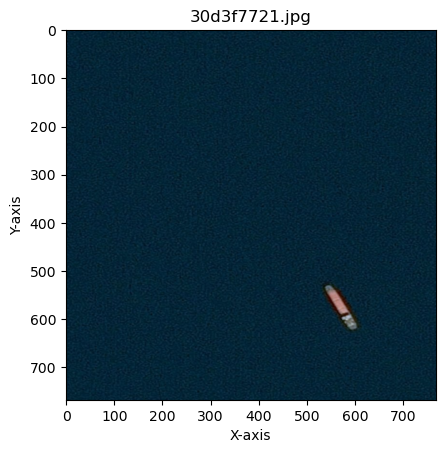

In [54]:
img = np.array(tr_img)
print('Image shape: {img.shape}')

plt.imshow(img)
plt.title(train_data[10])

plt.xlabel("X-axis")
plt.ylabel("Y-axis")

#### **Train set**
***

Below we could observe the images from the train set.

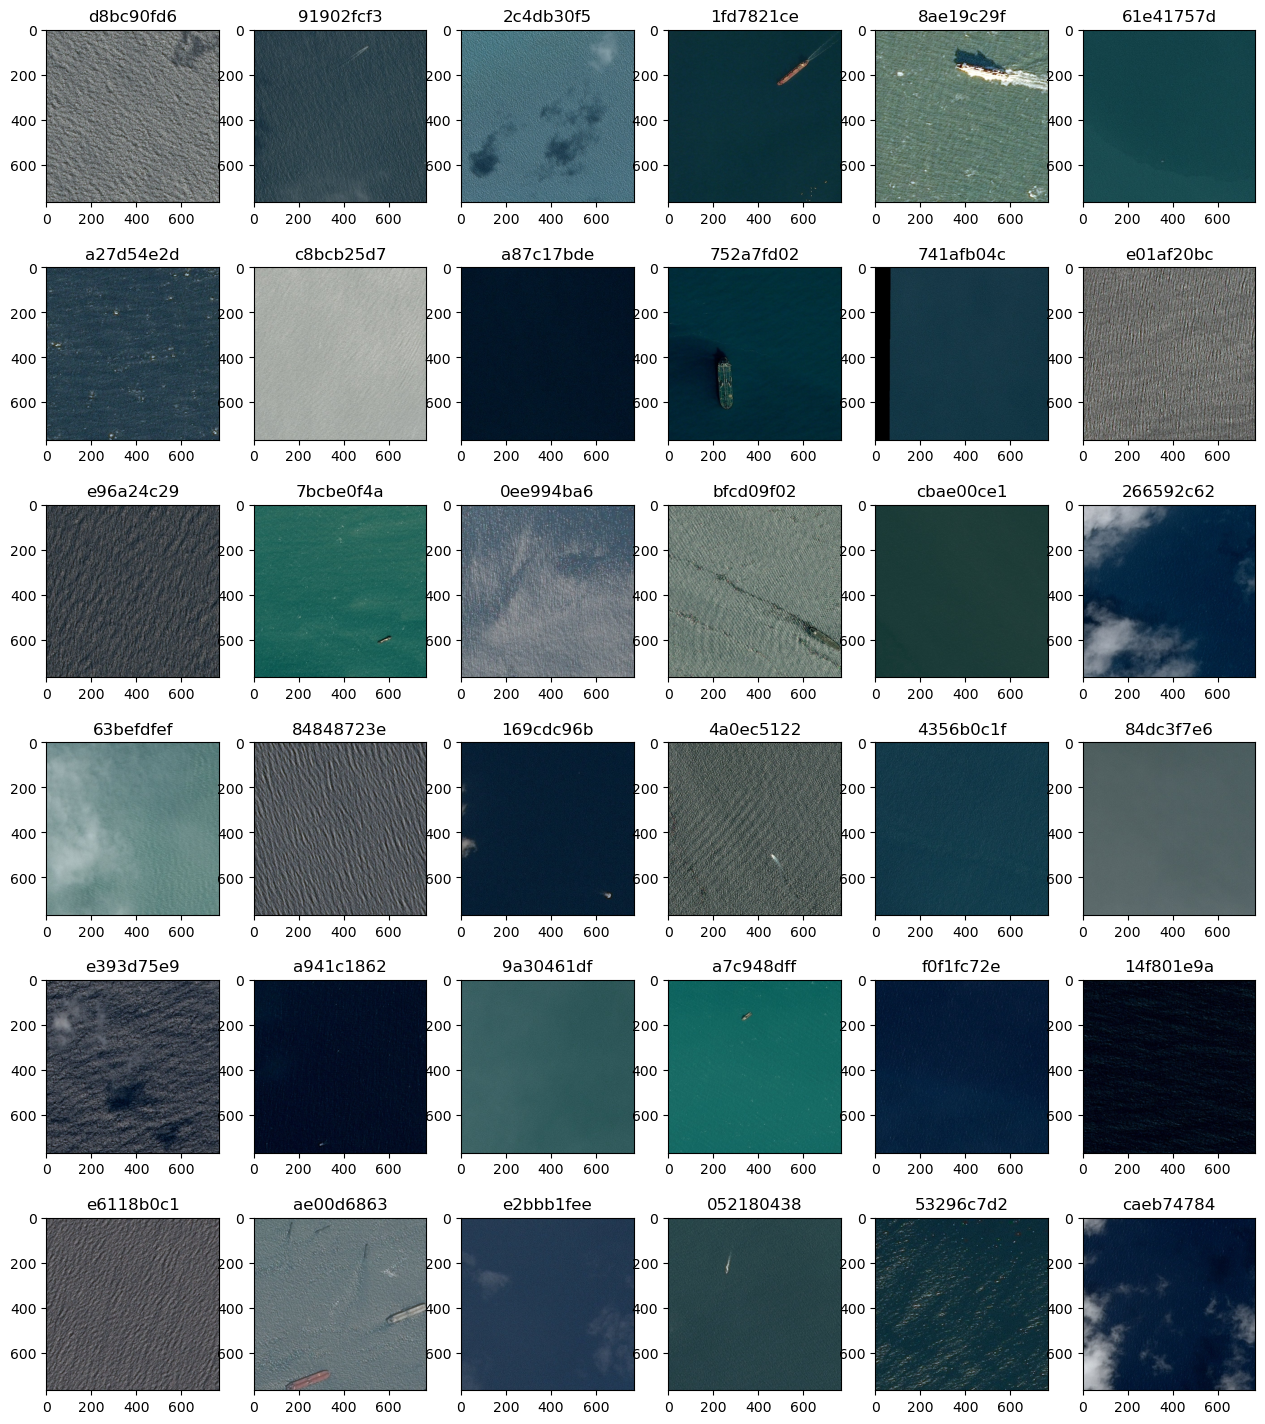

In [81]:
show_imgs(6, 6, 50, train_data, TRAIN_DATA_PATH)

#### **Test set**
***

Below we could observe the images from the test set.

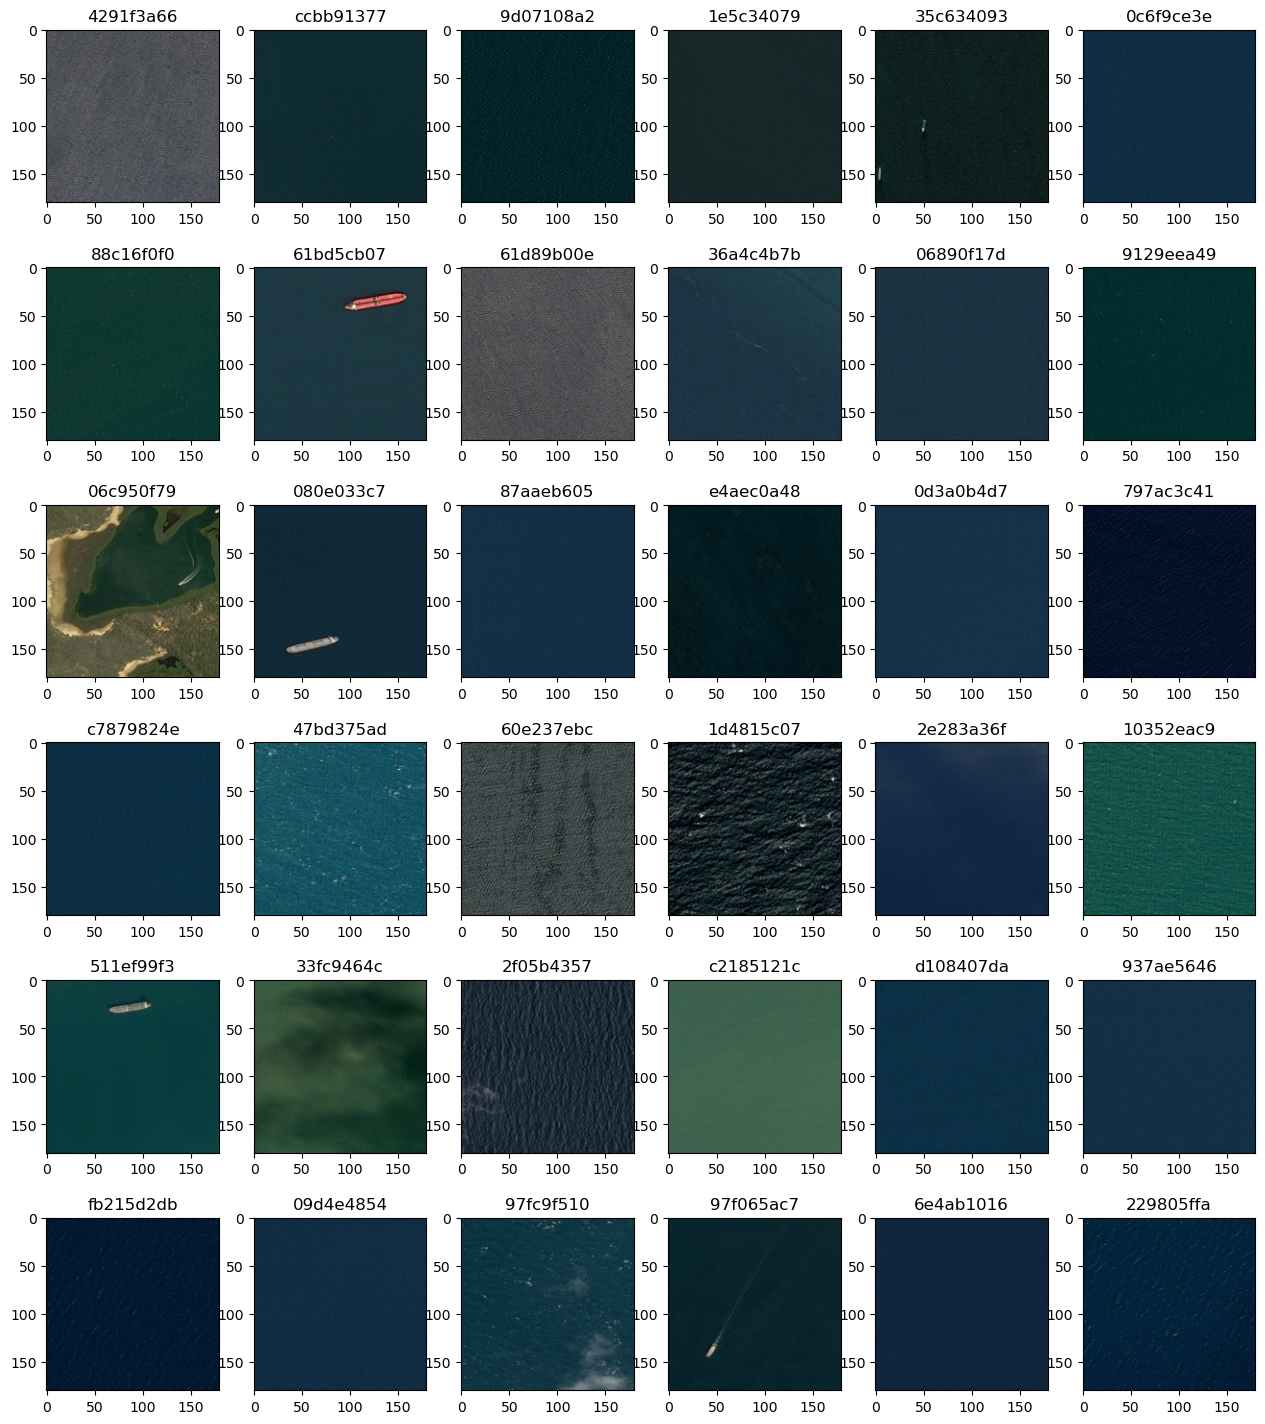

In [79]:
show_imgs(6, 6, 50, test_data, TEST_DATA_PATH)

### **Distribution exploration**
*** 

In this section would be discussed and examined the dataset's distribution.

In [5]:
masks_df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
eda_df = masks_df.copy()
eda_df['Ship_class'] = eda_df['EncodedPixels'].notnull().astype(int)
eda_df = eda_df.groupby("ImageId").agg({'Ship_class': ['first', 'sum']})
eda_df.columns =['Ship_class', 'Ship_amount']

eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192556 entries, 00003e153.jpg to ffffe97f3.jpg
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Ship_class   192556 non-null  int64
 1   Ship_amount  192556 non-null  int64
dtypes: int64(2)
memory usage: 4.4+ MB


In [6]:
print(f"The amount of images with the ships: {eda_df['Ship_class'].sum()}")
print(f"The amount of images without the ships: {len(eda_df) - eda_df['Ship_class'].sum()}")

The amount of images with the ships: 42556
The amount of images without the ships: 150000


In [16]:
eda_df[:10]

Ship_class  Ship_amount
ImageId                               
00003e153.jpg           0            0
0001124c7.jpg           0            0
000155de5.jpg           1            1
000194a2d.jpg           1            5
0001b1832.jpg           0            0
00021ddc3.jpg           1            9
0002756f7.jpg           1            2
0002d0f32.jpg           0            0
000303d4d.jpg           0            0
00031f145.jpg           1            1

Text(0.5, 1.0, 'Ship amount distribution')

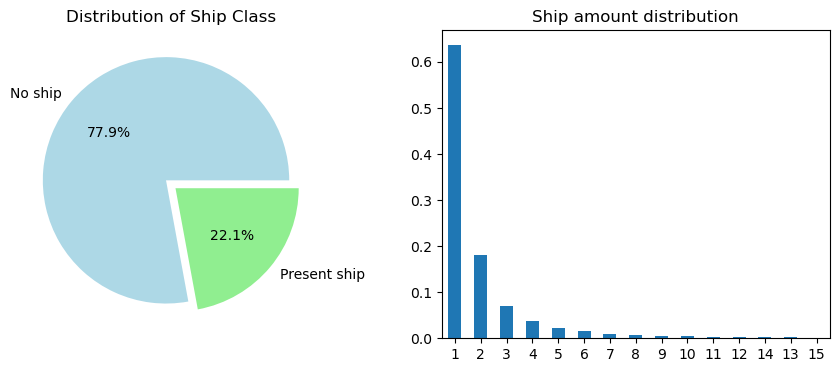

In [37]:
colors = ['lightblue', 'lightgreen']
sizes1 = eda_df.iloc[:, 0].value_counts()

ship_amount_values = eda_df.iloc[:, 1].unique()

value_counts = eda_df.iloc[:, 1].value_counts()[1:]
proportions = value_counts / value_counts.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

ax1.pie(sizes1, labels=['No ship', 'Present ship'], autopct='%1.1f%%', explode = (0.05, 0.05), colors=colors)
ax1.set_title('Distribution of Ship Class')

proportions.plot(kind='bar', ax=ax2, rot=0)
ax2.set_title('Ship amount distribution')


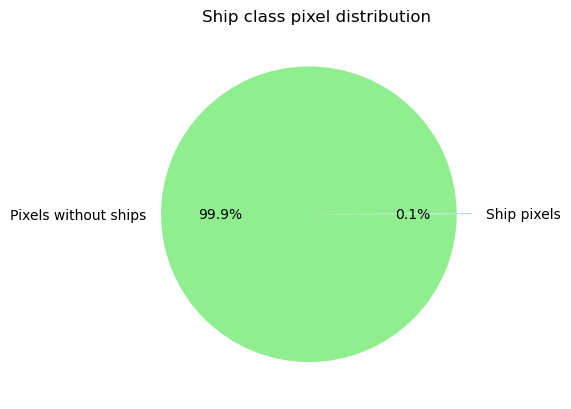

In [11]:
total_pixels = masks_df['ImageId'].nunique()*768**2 
ship_pixels = masks_df['EncodedPixels'].dropna().apply(decode_split).apply(len).sum() 

colors = ['lightblue', 'lightgreen']
labels = ['Ship pixels', 'Pixels without ships']
sizes = [ship_pixels, total_pixels-ship_pixels]

plt.pie(sizes, labels=labels,  autopct='%1.1f%%', explode = (0.05, 0.05), colors=colors)
plt.title('Ship class pixel distribution')
plt.show()

In [13]:
ratio = ship_pixels / total_pixels
print(f"Ship pixels: {ship_pixels, round(ratio, 4)}")
print(f"Pixels without ships: {total_pixels - ship_pixels, 1-round(ratio, 4)}")

Ship pixels: (128092863, 0.0011)
Pixels without ships: (113446057281, 0.9989)


From the above plots and statistics, we can conclude that our initial data is unbalanced, being more precise there prevail images without ships, which actually is a problem and needs consideration. A possible solution would be to take an equal proportion of each image class for the model training process or increase the amount of ships images, by sampling more data or by adding some augmentations to the existing ones. By balancing the proportion of images for each class, we can mitigate the potential bias towards the majority class and therefore improve the model's overall performance. In my case, for the modeling stage, I will the first approach: take an equal amount of images for each class.

## **Masks and RLE enocoding**
***

Initially, our masks are encoded in the RLE (Run-Length Encoding) format. So in order to use them for further analysis, in particular for visualization and modeling tasks, we need to decode them. The process of mask decoding will be carried out in this section, being more precise we will transform the compressed string representation into a pixel-wise format.

In [14]:
masks_df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
masks_df.dropna(inplace=True)
masks_df.reset_index(drop=True, inplace=True)

print(masks_df.info(), end='\n\n') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81723 entries, 0 to 81722
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        81723 non-null  object
 1   EncodedPixels  81723 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None



In [13]:
masks_df.head(10)

ImageId                                      EncodedPixels
0  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
1  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
2  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
4  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
5  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
6  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...
7  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
8  00021ddc3.jpg  74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
9  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...

In [123]:
print(masks_df['EncodedPixels'][0], end='\n\n')
temp_lst = masks_df['EncodedPixels'][0].split()
encoded_px = np.array([(int(temp_lst[idx]), int(temp_lst[idx+1])) for idx in range(0, len(temp_lst) - 1, 2)])
encoded_px[:10]

264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33 

array([[264661,     17],
       [265429,     33],
       [266197,     33],
       [266965,     33],
       [267733,     33],
       [268501,     33],
       [269269,     33],
       [270037,     33],
       [270805,     33],
       [271573,     33]])

#### **Decoded pixels**
***

Below you could observe the example of the mask's pixels, that were obtained after the RLE-string decoding process.

In [124]:
points = rle_decoder(encoded_px)
points[:10]

[(469, 344),
 (470, 344),
 (471, 344),
 (472, 344),
 (473, 344),
 (474, 344),
 (475, 344),
 (476, 344),
 (477, 344),
 (478, 344)]

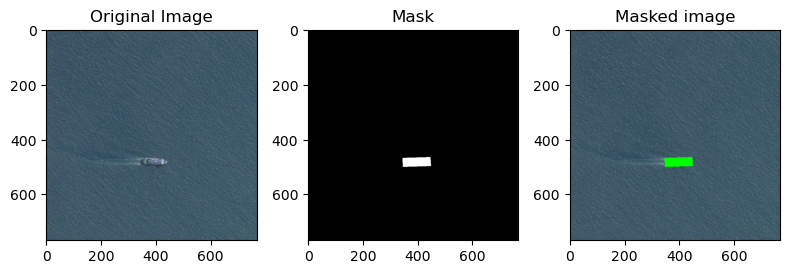

In [125]:
img = PIL.Image.open(os.path.join(TRAIN_DATA_PATH, masks_df['ImageId'][0]))
img = np.array(img)
msk_img = img.copy()
mask = np.zeros_like(img)

for point in points:
    mask[point[0], point[1]] = 255
    msk_img[point[0], point[1], [0, 2]] = 0
    msk_img[point[0], point[1], 1] = 255

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 5))
ax1.imshow(img)
ax1.set_title('Original Image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(msk_img)
ax3.set_title('Masked image')

plt.tight_layout()

#### **Aggregating data**
***

In this section, we would group our data frame with masks by images' id values. The purpose of this is to combine all encoded mask RLE strings associated with each image into a single row. This consolidation of masks within each image is very important as it facilitates further analysis and simplifies plotting tasks.

In [140]:
aggregated_df = masks_df.groupby('ImageId')[['EncodedPixels']].agg(lambda rle_encoded_px: ' '.join(rle_encoded_px))
img_names = aggregated_df.index.values
aggregated_df.reset_index(drop=True, inplace=True)

aggregated_df

EncodedPixels
0      264661 17 265429 33 266197 33 266965 33 267733...
1      360486 1 361252 4 362019 5 362785 8 363552 10 ...
2      108287 1 109054 3 109821 4 110588 5 111356 5 1...
3      255784 2 256552 4 257319 7 258087 9 258854 12 ...
4      340363 1 341129 4 341896 6 342663 7 343429 10 ...
...                                                  ...
42551  133056 1 133823 4 134591 6 135358 8 136126 10 ...
42552  441057 2 441825 4 442592 7 443360 9 444128 11 ...
42553  222782 4 223550 10 224318 14 225086 14 225854 ...
42554  110011 5 110779 5 111547 5 112315 5 113083 5 1...
42555  333603 7 334359 19 335120 26 335888 26 336656 ...

[42556 rows x 1 columns]

In [141]:
img_names

array(['000155de5.jpg', '000194a2d.jpg', '00021ddc3.jpg', ...,
       'fffcb6464.jpg', 'fffd924fb.jpg', 'fffdd2377.jpg'], dtype=object)

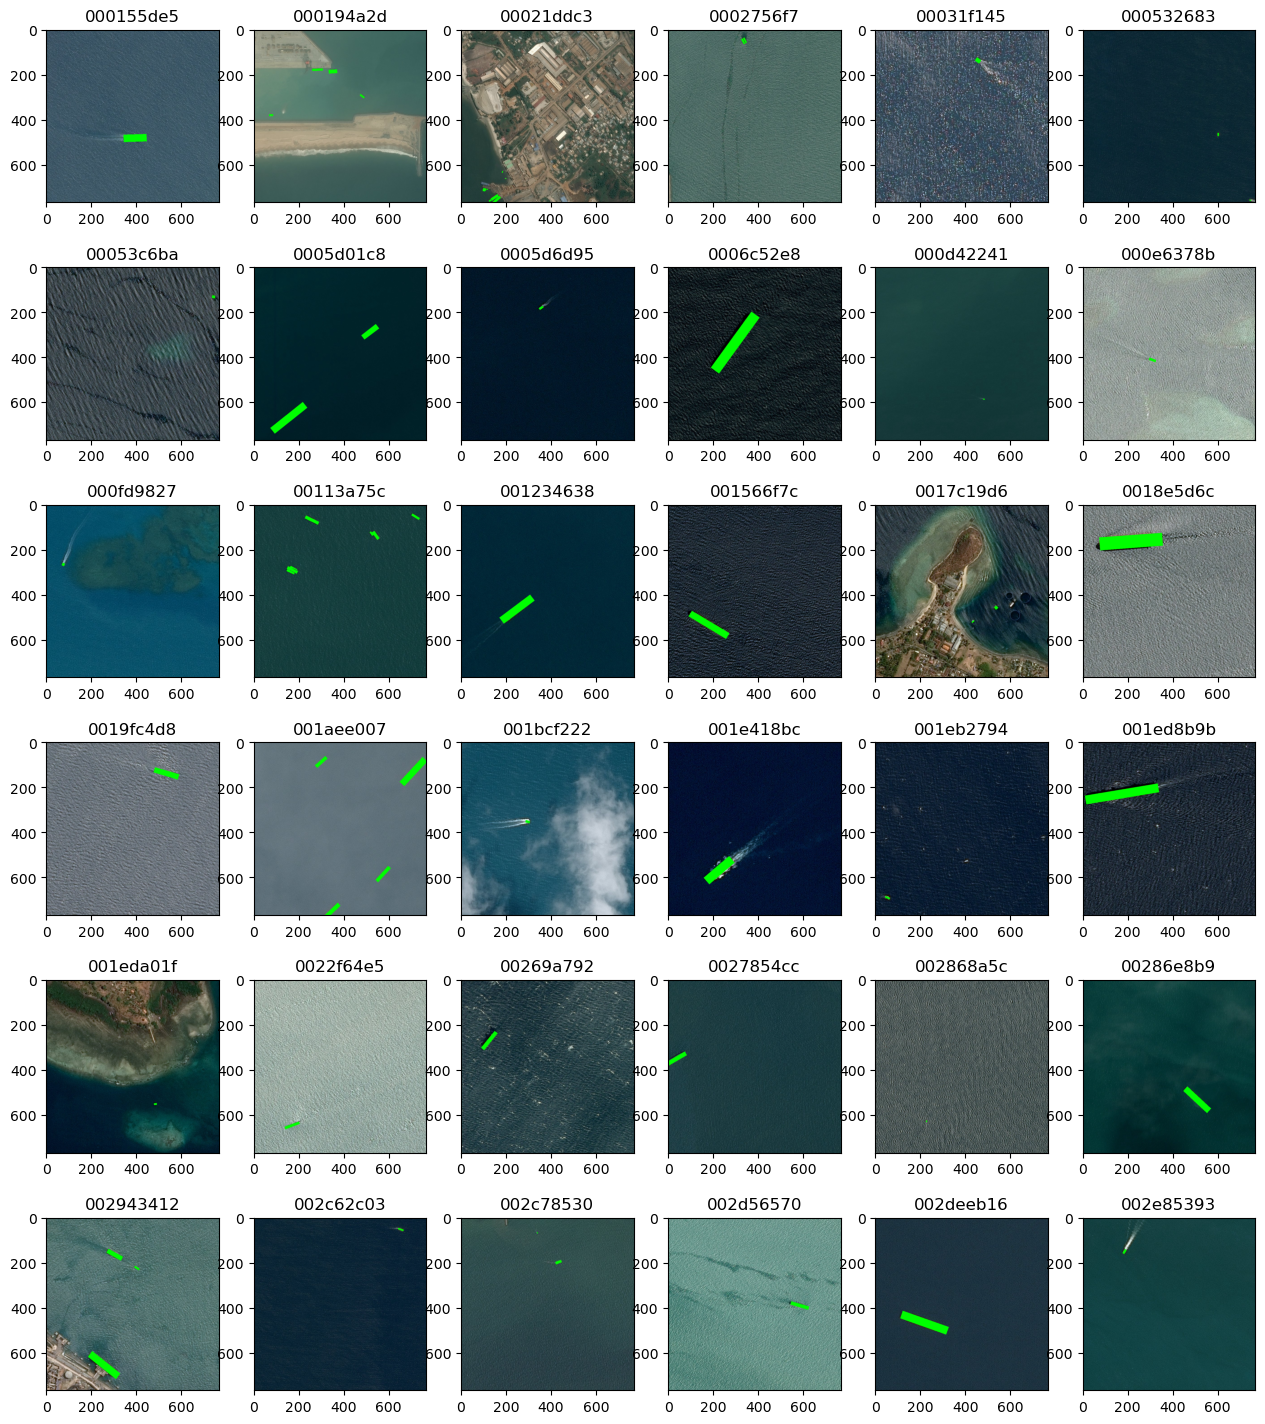

In [142]:
show_imgs(6, 6, 1, img_names, TRAIN_DATA_PATH, aggregated_df['EncodedPixels'])

## Conclusion
***

After conducting the initial exploratory data analysis (EDA), a key observation is that our dataset is unbalanced. Being more precise we have approximately 78% of pictures without ships and only 22% with. This poses a problem because if we train the model on this data as is, there is a high probability that it will overfit to the "no ship" class, resulting in poorer performance on photos with ships. To address this issue to we could try to balance data, for example, by taking eqaul amount of images with ships and without and then train on them a model. It's also important to note that unbalanced dataset problem become even worse if think in terms of pixels, becuase even on those images that contain ships the percentage of pixels occupied by the ships is relatively small compared to the overall image.